In [1]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.datasets as dset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [2]:
# Configuration parameters for training a Vision Transformer on MNIST dataset
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 50
LEARNING_RATE = 1e-4
NC = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNEL = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODE = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNEL
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channel):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channel,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channel, embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).transpose(1, 2)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)
        return x


In [4]:
model = PatchEmbedding(embed_dim=EMBED_DIM,
                       patch_size=PATCH_SIZE,
                       num_patches=NUM_PATCHES,
                       dropout=DROPOUT,
                       in_channel=IN_CHANNEL,).to(device)

In [5]:
# x = torch.randn(512, 1, 28, 28, device=device)
# print(model(x).shape)  # torch.Size([512, 50, 16])

In [6]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, embed_dim, num_encode, num_heads, hidden_dim, dropout, activation, in_channel):
        super().__init__()
        self.embedding_block = PatchEmbedding(embed_dim, patch_size=PATCH_SIZE, num_patches=num_patches, dropout=dropout, in_channel=in_channel)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encode)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes))

    def forward(self, x):
        x = self.embedding_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x
model = ViT(num_patches=NUM_PATCHES,
            num_classes=NC,
            embed_dim=EMBED_DIM,
            num_encode=NUM_ENCODE,
            num_heads=NUM_HEADS,
            hidden_dim=HIDDEN_DIM,
            dropout=DROPOUT,
            activation=ACTIVATION,
            in_channel=IN_CHANNEL).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [7]:
# x = torch.randn(512, 1, 28, 28)  # Ensure input tensor is on the same device as the model
# print(model(x).shape)  # torch.Size([512, 10])

In [8]:
train_dataset = dset.MNIST(root='./data',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)
test_dataset = dset.MNIST(root='./data',
                             train=False,
                             transform=transforms.ToTensor(),
                             download=True)

train_data, val_data = train_test_split(list(train_dataset), test_size=0.1, random_state=RANDOM_SEED, shuffle=True)
train_dataset = torch.utils.data.Subset(train_dataset, [i for i, _ in enumerate(train_data)])
val_dataset = torch.utils.data.Subset(train_dataset, [i for i, _ in enumerate(val_data)])


Text(0.5, 1.0, 'Val Sample')

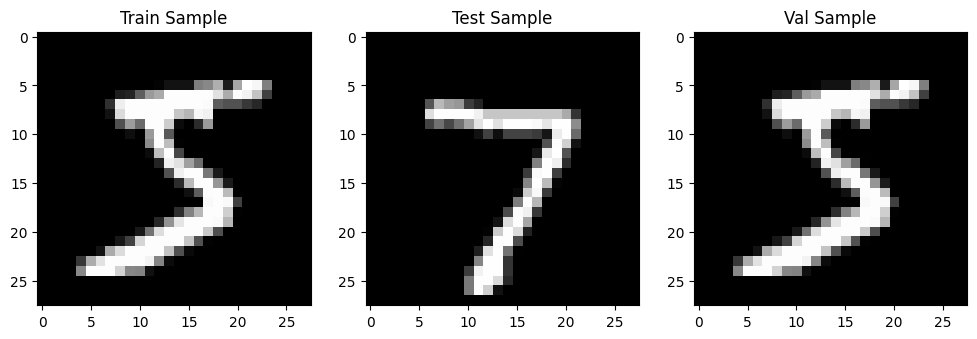

In [9]:
fiq, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(train_dataset[0][0].squeeze(), cmap='gray')
ax[0].set_title('Train Sample')
ax[1].imshow(test_dataset[0][0].squeeze(), cmap='gray')
ax[1].set_title('Test Sample')
ax[2].imshow(val_dataset[0][0].squeeze(), cmap='gray')
ax[2].set_title('Val Sample')

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, sampler=False)

In [11]:
# Inspect the first batch of the train_loader
for images, labels in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels}")
    break  # Only check the first batch

Images shape: torch.Size([512, 1, 28, 28])
Labels shape: torch.Size([512])
Labels: tensor([4, 2, 7, 4, 3, 8, 9, 1, 3, 0, 5, 7, 2, 5, 4, 4, 9, 2, 9, 5, 0, 6, 0, 7,
        7, 8, 9, 7, 9, 3, 7, 3, 7, 6, 6, 1, 6, 4, 7, 2, 1, 3, 3, 0, 0, 3, 6, 3,
        8, 5, 8, 2, 1, 1, 3, 5, 4, 9, 4, 0, 5, 5, 9, 4, 0, 7, 1, 1, 2, 2, 6, 2,
        4, 6, 5, 1, 5, 7, 5, 2, 6, 1, 9, 5, 0, 7, 7, 8, 1, 8, 9, 3, 1, 9, 0, 9,
        8, 9, 7, 1, 0, 0, 0, 3, 7, 5, 9, 1, 4, 2, 7, 0, 4, 4, 4, 6, 5, 0, 2, 7,
        8, 1, 6, 0, 8, 6, 4, 6, 3, 7, 6, 7, 8, 0, 2, 1, 0, 6, 3, 5, 7, 1, 1, 6,
        4, 0, 8, 8, 9, 7, 5, 3, 7, 9, 7, 3, 1, 2, 6, 2, 8, 0, 9, 2, 6, 4, 4, 7,
        4, 9, 5, 0, 2, 8, 6, 9, 6, 7, 3, 3, 3, 4, 9, 5, 7, 7, 4, 9, 7, 5, 0, 3,
        2, 2, 3, 4, 6, 7, 4, 6, 6, 3, 9, 6, 3, 6, 7, 1, 7, 1, 4, 1, 9, 2, 7, 5,
        9, 4, 1, 4, 7, 7, 5, 3, 0, 2, 6, 1, 0, 2, 1, 1, 8, 3, 9, 4, 0, 2, 2, 6,
        4, 1, 4, 3, 2, 0, 5, 4, 2, 8, 7, 6, 6, 7, 0, 2, 8, 6, 4, 9, 3, 7, 7, 3,
        2, 0, 4, 3, 4, 2, 4, 1, 2, 5,

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_label = []
    train_pred = []
    train_running_loss = 0
    for idx, (img, label) in enumerate(tqdm(train_loader, position=0, leave=True)):
        img = img.to(device)
        label = label.to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_label.extend(label.cpu().detach())
        train_pred.extend(y_pred_label.cpu().detach())

        # Checking the shapes for loss calculation
        # print(f"y_pred shape: {y_pred.shape}, label shape: {label.shape}")

        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_label = []
    val_pread = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, (img, label) in enumerate(tqdm(val_loader, position=0, leave=True)):
            img = img.to(device)
            label = label.to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_label.extend(label.cpu().detach())
            val_pread.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
        val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train Acc EPOCH {epoch+1}: {sum(1 for x, y in zip(train_label, train_pred) if x==y) / len(train_label):.4f}")
    print(f"Val Acc EPOCH {epoch+1}: {sum(1 for x, y in zip(val_label, val_pread) if x==y) / len(val_label):.4f}")
    print("-"*30)

end = timeit.default_timer()
print(f"Training Time: {end - start} seconds")

100%|██████████| 12/12 [00:02<00:00,  4.47it/s]


------------------------------
Epoch [1/50], Train Loss: 2.3054, Val Loss: 2.2891


  2%|▏         | 1/50 [00:22<18:00, 22.06s/it]

Train Acc EPOCH 1: 0.1141
Val Acc EPOCH 1: 0.1365
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.64it/s]


------------------------------
Epoch [2/50], Train Loss: 1.9165, Val Loss: 1.6040
Train Acc EPOCH 2: 0.3268


  4%|▍         | 2/50 [00:40<15:44, 19.67s/it]

Val Acc EPOCH 2: 0.4963
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.38it/s]


------------------------------
Epoch [3/50], Train Loss: 1.4706, Val Loss: 1.2695


  6%|▌         | 3/50 [00:58<14:57, 19.10s/it]

Train Acc EPOCH 3: 0.5596
Val Acc EPOCH 3: 0.6650
------------------------------


100%|██████████| 12/12 [00:01<00:00,  9.96it/s]


------------------------------
Epoch [4/50], Train Loss: 1.2373, Val Loss: 1.0747


  8%|▊         | 4/50 [01:16<14:20, 18.70s/it]

Train Acc EPOCH 4: 0.6657
Val Acc EPOCH 4: 0.7412
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.51it/s]


------------------------------
Epoch [5/50], Train Loss: 1.0548, Val Loss: 0.8953


 10%|█         | 5/50 [01:34<13:51, 18.48s/it]

Train Acc EPOCH 5: 0.7376
Val Acc EPOCH 5: 0.8040
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.58it/s]


------------------------------
Epoch [6/50], Train Loss: 0.9209, Val Loss: 0.7948
Train Acc EPOCH 6: 0.7783


 12%|█▏        | 6/50 [01:52<13:25, 18.31s/it]

Val Acc EPOCH 6: 0.8278
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.87it/s]


------------------------------
Epoch [7/50], Train Loss: 0.8213, Val Loss: 0.6886
Train Acc EPOCH 7: 0.8034


 14%|█▍        | 7/50 [02:10<13:05, 18.28s/it]

Val Acc EPOCH 7: 0.8530
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.74it/s]


------------------------------
Epoch [8/50], Train Loss: 0.7381, Val Loss: 0.6410
Train Acc EPOCH 8: 0.8249


 16%|█▌        | 8/50 [02:28<12:44, 18.21s/it]

Val Acc EPOCH 8: 0.8597
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.56it/s]


------------------------------
Epoch [9/50], Train Loss: 0.6703, Val Loss: 0.5781
Train Acc EPOCH 9: 0.8408


 18%|█▊        | 9/50 [02:47<12:27, 18.24s/it]

Val Acc EPOCH 9: 0.8727
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.51it/s]


------------------------------
Epoch [10/50], Train Loss: 0.6157, Val Loss: 0.5370
Train Acc EPOCH 10: 0.8514


 20%|██        | 10/50 [03:05<12:08, 18.20s/it]

Val Acc EPOCH 10: 0.8755
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.23it/s]


------------------------------
Epoch [11/50], Train Loss: 0.5719, Val Loss: 0.4875
Train Acc EPOCH 11: 0.8587


 22%|██▏       | 11/50 [03:23<11:51, 18.26s/it]

Val Acc EPOCH 11: 0.8870
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.22it/s]


------------------------------
Epoch [12/50], Train Loss: 0.5310, Val Loss: 0.4584


 24%|██▍       | 12/50 [03:41<11:31, 18.20s/it]

Train Acc EPOCH 12: 0.8677
Val Acc EPOCH 12: 0.8927
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.61it/s]


------------------------------
Epoch [13/50], Train Loss: 0.5089, Val Loss: 0.4073
Train Acc EPOCH 13: 0.8696


 26%|██▌       | 13/50 [04:00<11:14, 18.23s/it]

Val Acc EPOCH 13: 0.9048
------------------------------


100%|██████████| 12/12 [00:01<00:00,  9.80it/s]


------------------------------
Epoch [14/50], Train Loss: 0.4725, Val Loss: 0.3960


 28%|██▊       | 14/50 [04:18<10:54, 18.19s/it]

Train Acc EPOCH 14: 0.8786
Val Acc EPOCH 14: 0.9043
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.25it/s]


------------------------------
Epoch [15/50], Train Loss: 0.4434, Val Loss: 0.3596


 30%|███       | 15/50 [04:36<10:40, 18.31s/it]

Train Acc EPOCH 15: 0.8856
Val Acc EPOCH 15: 0.9132
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.73it/s]


------------------------------
Epoch [16/50], Train Loss: 0.4095, Val Loss: 0.3399
Train Acc EPOCH 16: 0.8939


 32%|███▏      | 16/50 [04:54<10:19, 18.22s/it]

Val Acc EPOCH 16: 0.9178
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.55it/s]


------------------------------
Epoch [17/50], Train Loss: 0.3830, Val Loss: 0.3348


 34%|███▍      | 17/50 [05:13<10:03, 18.28s/it]

Train Acc EPOCH 17: 0.9002
Val Acc EPOCH 17: 0.9212
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.02it/s]


------------------------------
Epoch [18/50], Train Loss: 0.3584, Val Loss: 0.3098


 36%|███▌      | 18/50 [05:31<09:45, 18.30s/it]

Train Acc EPOCH 18: 0.9061
Val Acc EPOCH 18: 0.9228
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.48it/s]


------------------------------
Epoch [19/50], Train Loss: 0.3446, Val Loss: 0.2920
Train Acc EPOCH 19: 0.9082


 38%|███▊      | 19/50 [05:49<09:27, 18.30s/it]

Val Acc EPOCH 19: 0.9268
------------------------------


100%|██████████| 12/12 [00:01<00:00,  9.73it/s]


------------------------------
Epoch [20/50], Train Loss: 0.3295, Val Loss: 0.2677


 40%|████      | 20/50 [06:08<09:11, 18.39s/it]

Train Acc EPOCH 20: 0.9127
Val Acc EPOCH 20: 0.9298
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.47it/s]


------------------------------
Epoch [21/50], Train Loss: 0.3110, Val Loss: 0.2722
Train Acc EPOCH 21: 0.9172


 42%|████▏     | 21/50 [06:26<08:51, 18.34s/it]

Val Acc EPOCH 21: 0.9300
------------------------------


100%|██████████| 12/12 [00:01<00:00,  9.93it/s]


------------------------------
Epoch [22/50], Train Loss: 0.2940, Val Loss: 0.2394
Train Acc EPOCH 22: 0.9213


 44%|████▍     | 22/50 [06:45<08:34, 18.37s/it]

Val Acc EPOCH 22: 0.9405
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.56it/s]


------------------------------
Epoch [23/50], Train Loss: 0.2900, Val Loss: 0.2451
Train Acc EPOCH 23: 0.9203


 46%|████▌     | 23/50 [07:03<08:13, 18.29s/it]

Val Acc EPOCH 23: 0.9363
------------------------------


100%|██████████| 12/12 [00:01<00:00,  8.04it/s]


------------------------------
Epoch [24/50], Train Loss: 0.2810, Val Loss: 0.2222
Train Acc EPOCH 24: 0.9229


 48%|████▊     | 24/50 [07:21<07:57, 18.35s/it]

Val Acc EPOCH 24: 0.9425
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.58it/s]


------------------------------
Epoch [25/50], Train Loss: 0.2662, Val Loss: 0.2321
Train Acc EPOCH 25: 0.9283


 50%|█████     | 25/50 [07:39<07:35, 18.23s/it]

Val Acc EPOCH 25: 0.9397
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.79it/s]


------------------------------
Epoch [26/50], Train Loss: 0.2640, Val Loss: 0.2339
Train Acc EPOCH 26: 0.9272


 52%|█████▏    | 26/50 [07:57<07:18, 18.25s/it]

Val Acc EPOCH 26: 0.9355
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.17it/s]


------------------------------
Epoch [27/50], Train Loss: 0.2585, Val Loss: 0.2475


 54%|█████▍    | 27/50 [08:16<06:59, 18.23s/it]

Train Acc EPOCH 27: 0.9275
Val Acc EPOCH 27: 0.9310
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.58it/s]


------------------------------
Epoch [28/50], Train Loss: 0.2453, Val Loss: 0.2079
Train Acc EPOCH 28: 0.9318


 56%|█████▌    | 28/50 [08:34<06:42, 18.29s/it]

Val Acc EPOCH 28: 0.9417
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.41it/s]


------------------------------
Epoch [29/50], Train Loss: 0.2357, Val Loss: 0.2090
Train Acc EPOCH 29: 0.9344


 58%|█████▊    | 29/50 [08:52<06:23, 18.26s/it]

Val Acc EPOCH 29: 0.9460
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.41it/s]


------------------------------
Epoch [30/50], Train Loss: 0.2283, Val Loss: 0.1817


 60%|██████    | 30/50 [09:11<06:06, 18.31s/it]

Train Acc EPOCH 30: 0.9356
Val Acc EPOCH 30: 0.9522
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.50it/s]


------------------------------
Epoch [31/50], Train Loss: 0.2187, Val Loss: 0.1771
Train Acc EPOCH 31: 0.9378


 62%|██████▏   | 31/50 [09:29<05:48, 18.36s/it]

Val Acc EPOCH 31: 0.9507
------------------------------


100%|██████████| 12/12 [00:01<00:00, 11.68it/s]


------------------------------
Epoch [32/50], Train Loss: 0.2151, Val Loss: 0.1820
Train Acc EPOCH 32: 0.9384


 64%|██████▍   | 32/50 [09:48<05:30, 18.38s/it]

Val Acc EPOCH 32: 0.9497
------------------------------


100%|██████████| 12/12 [00:01<00:00,  8.99it/s]


------------------------------
Epoch [33/50], Train Loss: 0.2118, Val Loss: 0.1720


 66%|██████▌   | 33/50 [10:06<05:12, 18.37s/it]

Train Acc EPOCH 33: 0.9394
Val Acc EPOCH 33: 0.9520
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.50it/s]


------------------------------
Epoch [34/50], Train Loss: 0.1992, Val Loss: 0.1661
Train Acc EPOCH 34: 0.9438


 68%|██████▊   | 34/50 [10:24<04:52, 18.28s/it]

Val Acc EPOCH 34: 0.9550
------------------------------


100%|██████████| 12/12 [00:01<00:00,  9.44it/s]


------------------------------
Epoch [35/50], Train Loss: 0.1999, Val Loss: 0.1700


 70%|███████   | 35/50 [10:43<04:35, 18.38s/it]

Train Acc EPOCH 35: 0.9429
Val Acc EPOCH 35: 0.9512
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.01it/s]


------------------------------
Epoch [36/50], Train Loss: 0.2010, Val Loss: 0.1591


 72%|███████▏  | 36/50 [11:01<04:16, 18.33s/it]

Train Acc EPOCH 36: 0.9422
Val Acc EPOCH 36: 0.9540
------------------------------


100%|██████████| 12/12 [00:01<00:00,  7.73it/s]


------------------------------
Epoch [37/50], Train Loss: 0.1952, Val Loss: 0.1567
Train Acc EPOCH 37: 0.9433


 74%|███████▍  | 37/50 [11:20<04:00, 18.50s/it]

Val Acc EPOCH 37: 0.9555
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.42it/s]


------------------------------
Epoch [38/50], Train Loss: 0.1874, Val Loss: 0.1393
Train Acc EPOCH 38: 0.9456


 76%|███████▌  | 38/50 [11:37<03:39, 18.28s/it]

Val Acc EPOCH 38: 0.9603
------------------------------


100%|██████████| 12/12 [00:01<00:00, 10.96it/s]


------------------------------
Epoch [39/50], Train Loss: 0.1823, Val Loss: 0.1495


 78%|███████▊  | 39/50 [11:56<03:21, 18.35s/it]

Train Acc EPOCH 39: 0.9465
Val Acc EPOCH 39: 0.9573
------------------------------


100%|██████████| 12/12 [00:01<00:00,  9.66it/s]


------------------------------
Epoch [40/50], Train Loss: 0.1787, Val Loss: 0.1314


 80%|████████  | 40/50 [12:14<03:03, 18.35s/it]

Train Acc EPOCH 40: 0.9481
Val Acc EPOCH 40: 0.9645
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.62it/s]


------------------------------
Epoch [41/50], Train Loss: 0.1769, Val Loss: 0.1596
Train Acc EPOCH 41: 0.9475


 82%|████████▏ | 41/50 [12:33<02:44, 18.29s/it]

Val Acc EPOCH 41: 0.9540
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.38it/s]


------------------------------
Epoch [42/50], Train Loss: 0.1716, Val Loss: 0.1409
Train Acc EPOCH 42: 0.9491


 84%|████████▍ | 42/50 [12:51<02:25, 18.21s/it]

Val Acc EPOCH 42: 0.9608
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.51it/s]


------------------------------
Epoch [43/50], Train Loss: 0.1682, Val Loss: 0.1289


 86%|████████▌ | 43/50 [13:09<02:08, 18.30s/it]

Train Acc EPOCH 43: 0.9507
Val Acc EPOCH 43: 0.9632
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.10it/s]


------------------------------
Epoch [44/50], Train Loss: 0.1612, Val Loss: 0.1326
Train Acc EPOCH 44: 0.9525


 88%|████████▊ | 44/50 [13:27<01:49, 18.24s/it]

Val Acc EPOCH 44: 0.9613
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.34it/s]


------------------------------
Epoch [45/50], Train Loss: 0.1632, Val Loss: 0.1366
Train Acc EPOCH 45: 0.9515


 90%|█████████ | 45/50 [13:46<01:31, 18.37s/it]

Val Acc EPOCH 45: 0.9580
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.67it/s]


------------------------------
Epoch [46/50], Train Loss: 0.1645, Val Loss: 0.1317
Train Acc EPOCH 46: 0.9501


 92%|█████████▏| 46/50 [14:04<01:13, 18.29s/it]

Val Acc EPOCH 46: 0.9642
------------------------------


100%|██████████| 12/12 [00:00<00:00, 12.33it/s]


------------------------------
Epoch [47/50], Train Loss: 0.1597, Val Loss: 0.1246


 94%|█████████▍| 47/50 [14:23<00:55, 18.40s/it]

Train Acc EPOCH 47: 0.9524
Val Acc EPOCH 47: 0.9645
------------------------------


100%|██████████| 12/12 [00:01<00:00, 11.65it/s]


------------------------------
Epoch [48/50], Train Loss: 0.1597, Val Loss: 0.1283


 96%|█████████▌| 48/50 [14:41<00:37, 18.51s/it]

Train Acc EPOCH 48: 0.9523
Val Acc EPOCH 48: 0.9662
------------------------------


100%|██████████| 12/12 [00:01<00:00, 11.86it/s]


------------------------------
Epoch [49/50], Train Loss: 0.1486, Val Loss: 0.1376


 98%|█████████▊| 49/50 [15:00<00:18, 18.46s/it]

Train Acc EPOCH 49: 0.9554
Val Acc EPOCH 49: 0.9600
------------------------------


100%|██████████| 12/12 [00:01<00:00,  9.48it/s]


------------------------------
Epoch [50/50], Train Loss: 0.1478, Val Loss: 0.1280


100%|██████████| 50/50 [15:18<00:00, 18.37s/it]

Train Acc EPOCH 50: 0.9558
Val Acc EPOCH 50: 0.9632
------------------------------
Training Time: 918.709985537 seconds


In [14]:
torch.save(model.state_dict(), 'ViT_Digits.pth')

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

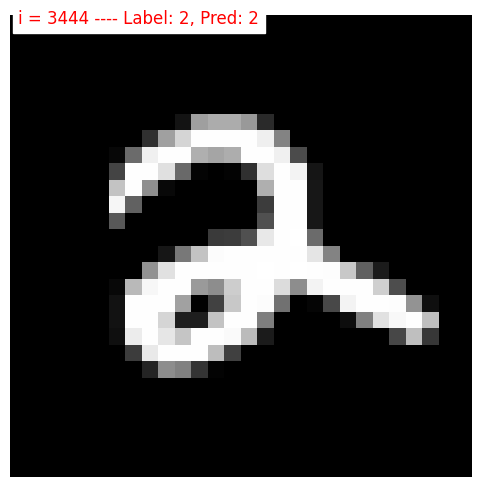

In [30]:
i = np.random.randint(0, len(val_dataset))
val_example = val_dataset[i][0].unsqueeze(0).to(device)
val_label_example = val_dataset[i][1]
val_pred_example = torch.argmax(model(val_example), dim=1)
# print(f"i = {i} ---- Label: {val_label_example}, Pred: {val_pred_example}")
plt.figure(figsize=(8, 6))
plt.imshow(val_example.cpu().detach().squeeze(), cmap='gray')
plt.text(0, 0, f"i = {i} ---- Label: {val_label_example}, Pred: {val_pred_example.item()}",
         color='red', fontsize=12, backgroundcolor='white')
plt.axis('off')